# Query Pan-STARRS DR2 catalog using CasJobs

This script shows how to query the Pan-STARRS DR2 catalog using a Python interface to Casjobs.  The examples show how to do a simple cone search, how to manipulate the table of results, and how to get a light curve from the table of detections.

This relies on the mastcasjobs Python module.  Follow the installation instructions given here:
https://github.com/rlwastro/mastcasjobs.

You must have a MAST Casjobs account (see https://mastweb.stsci.edu/ps1casjobs to create one).  Note that MAST Casjobs accounts are independent of SDSS Casjobs accounts.

For easy startup, set the `CASJOBS_WSID` and `CASJOBS_PW` environment variables with your Casjobs account information.  You can get your WSID by going to https://mastweb.stsci.edu/ps1casjobs/changedetails.aspx after you login to Casjobs.  Your password is what you enter when logging into Casjobs.

This script prompts for your Casjobs WSID and password if the environment variables are not defined.

You can also specify your wsid and password directly in the MastCasJobs initialization using the userid and password keyword parameters.

This notebook is available for [download](https://ps1images.stsci.edu/ps1_dr2_query.ipynb).

In [1]:
%matplotlib inline
import mastcasjobs
from astropy.io import ascii
from astropy.table import Table

import sys
import os
import re
import numpy as np
import pylab
import json

try: # Python 3.x
    from urllib.parse import quote as urlencode
    from urllib.request import urlretrieve
except ImportError:  # Python 2.x
    from urllib import pathname2url as urlencode
    from urllib import urlretrieve

try: # Python 3.x
    import http.client as httplib 
except ImportError:  # Python 2.x
    import httplib

# get the WSID and password if not already defined
import getpass
if not os.environ.get('CASJOBS_WSID'):
    os.environ['CASJOBS_WSID'] = input('Enter Casjobs WSID:')
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = getpass.getpass('Enter Casjobs password:')

## Useful functions

Resolve names using [MAST query](https://mast.stsci.edu/api/v0/MastApiTutorial.html) and fix up column names returned from Casjobs.

In [2]:
def mastQuery(request):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object

    Returns head,content where head is the response HTTP headers, and content is the returned data"""
    
    server='mast.stsci.edu'

    # Grab Python Version 
    version = ".".join(map(str, sys.version_info[:3]))

    # Create Http Header Variables
    headers = {"Content-type": "application/x-www-form-urlencoded",
               "Accept": "text/plain",
               "User-agent":"python-requests/"+version}

    # Encoding the request as a json string
    requestString = json.dumps(request)
    requestString = urlencode(requestString)
    
    # opening the https connection
    conn = httplib.HTTPSConnection(server)

    # Making the query
    conn.request("POST", "/api/v0/invoke", "request="+requestString, headers)

    # Getting the response
    resp = conn.getresponse()
    head = resp.getheaders()
    content = resp.read().decode('utf-8')

    # Close the https connection
    conn.close()

    return head,content


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    headers,resolvedObjectString = mastQuery(resolverRequest)
    resolvedObject = json.loads(resolvedObjectString)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)


def fixcolnames(tab):
    """Fix column names returned by the casjobs query
    
    Parameters
    ----------
    tab (astropy.table.Table): Input table

    Returns reference to original table with column names modified"""

    pat = re.compile(r'\[(?P<name>[^[]+)\]')
    for c in tab.colnames:
        m = pat.match(c)
        if not m:
            raise ValueError("Unable to parse column name '{}'".format(c))
        newname = m.group('name')
        tab.rename_column(c,newname)
    return tab

## Simple positional query

This searches the mean object catalog for objects within 50 arcsec of M87 (RA=187.706, Dec=12.391 in degrees). The `fGetNearbyObjEq` function returns a list of object IDs, and the subsequent joins extract information from the [ObjectThin](https://outerspace.stsci.edu/x/W4Oc) table (which has information on object positions and the number of available measurements) and the [MeanObject](https://outerspace.stsci.edu/x/WYOc) table (which has information on photometry averaged over the multiple epochs of observation).

Note that the results are restricted to objects with `nDetections>1`, where `nDetections` is the total number of times the object was detected on the single-epoch images in any filter at any time.  Objects with `nDetections=1` tend to be  artifacts, so this is a quick way to eliminate most spurious objects from the catalog.

This query runs in the interactive "quick" Casjobs queue, where the function pauses until the query is complete and returns the results as a CSV string.  __If one of these queries times out (which can happen if the database server is heavily loaded), try simply running it again.__  Often the same query will succeed the second time.

The more robust way to handle long-running queries is to run them in batch mode, but that requires waiting in the Casjobs queue if the system is busy.

In [3]:
query = """select o.objID, o.raMean, o.decMean,
o.nDetections, o.ng, o.nr, o.ni, o.nz, o.ny,
m.gMeanPSFMag, m.rMeanPSFMag, m.iMeanPSFMag, m.zMeanPSFMag, m.yMeanPSFMag
from fGetNearbyObjEq(187.706,12.391,50.0/60.0) nb
inner join ObjectThin o on o.objid=nb.objid and o.nDetections>1
inner join MeanObject m on o.objid=m.objid and o.uniquePspsOBid=m.uniquePspsOBid
"""

jobs = mastcasjobs.MastCasJobs(context="PanSTARRS_DR2")
results = jobs.quick(query, task_name="python cone search")
print(results)

[objID]:Integer,[raMean]:Float,[decMean]:Float,[nDetections]:Integer,[ng]:Integer,[nr]:Integer,[ni]:Integer,[nz]:Integer,[ny]:Integer,[gMeanPSFMag]:Float,[rMeanPSFMag]:Float,[iMeanPSFMag]:Float,[zMeanPSFMag]:Float,[yMeanPSFMag]:Float
122861877070368181,187.70700504,12.38964881,2,0,2,0,0,0,-999,15.2261,-999,-999,-999
122861877090664549,187.70906689,12.38671491,2,0,0,0,0,2,-999,-999,-999,-999,-999
122861877111116495,187.71111183,12.38833651,2,1,1,0,0,0,-999,-999,-999,-999,-999
122861877112026930,187.71120247,12.38869951,2,0,1,1,0,0,-999,-999,-999,-999,-999
122861877184282370,187.7182975,12.38498455,2,0,0,2,0,0,-999,-999,18.1435,-999,-999
122871876925340070,187.69247065,12.39128192,6,2,1,2,1,0,19.3276,19.0171,19.5632,19.2438,-999
122871876941435711,187.6940799,12.3959326,4,0,1,2,1,0,-999,-999,19.0092,19.1839,-999
122871876945758919,187.69449749,12.39870483,2,0,1,1,0,0,-999,20.8721,19.6038,-999,-999
122871876946391889,187.6946297,12.39284071,2,0,2,0,0,0,-999,17.6493,-999,-999,-999
12287187

### Convert the results to an astropy table

The CSV results string is easily converted to an [astropy table](http://docs.astropy.org/en/stable/table/).  The column names are messy (with embedded datatypes), so the `fixcolnames` function (defined above) is called to clean up the names.  This table is easily manipulated to extract information on individual columns or rows.

In [4]:
tab = fixcolnames(ascii.read(results))
tab

objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
122861877070368181,187.70700504,12.38964881,2,0,2,0,0,0,-999.0,15.2261,-999.0,-999.0,-999.0
122861877090664549,187.70906689,12.38671491,2,0,0,0,0,2,-999.0,-999.0,-999.0,-999.0,-999.0
122861877111116495,187.71111183,12.38833651,2,1,1,0,0,0,-999.0,-999.0,-999.0,-999.0,-999.0
122861877112026930,187.71120247,12.38869951,2,0,1,1,0,0,-999.0,-999.0,-999.0,-999.0,-999.0
122861877184282370,187.7182975,12.38498455,2,0,0,2,0,0,-999.0,-999.0,18.1435,-999.0,-999.0
122871876925340070,187.69247065,12.39128192,6,2,1,2,1,0,19.3276,19.0171,19.5632,19.2438,-999.0
122871876941435711,187.6940799,12.3959326,4,0,1,2,1,0,-999.0,-999.0,19.0092,19.1839,-999.0
122871876945758919,187.69449749,12.39870483,2,0,1,1,0,0,-999.0,20.8721,19.6038,-999.0,-999.0
122871876946391889,187.6946297,12.39284071,2,0,2,0,0,0,-999.0,17.6493,-999.0,-999.0,-999.0


## Get DR2 light curve for RR Lyrae star KQ UMa

This time we start with the object name, use the MAST name resolver (which relies on Simbad and NED) to convert the name to RA and Dec, and then query the PS1 DR2 mean object catalog at that position.  This time we use the `fGetNearestObjEq` function to select just the object closest to the search position.

In [5]:
objname = 'KQ UMa'
ra, dec = resolve(objname)
radius = 1.0/60.0 # radius = 1 arcsec

query = """select o.objID, o.raMean, o.decMean,
o.nDetections, o.ng, o.nr, o.ni, o.nz, o.ny,
m.gMeanPSFMag, m.rMeanPSFMag, m.iMeanPSFMag, m.zMeanPSFMag, m.yMeanPSFMag
from fGetNearestObjEq({},{},{}) nb
inner join ObjectThin o on o.objid=nb.objid and o.nDetections>1
inner join MeanObject m on o.objid=m.objid and o.uniquePspsOBid=m.uniquePspsOBid
""".format(ra,dec,radius)

print(query)

jobs = mastcasjobs.MastCasJobs(context="PanSTARRS_DR2")
results = jobs.quick(query, task_name="python cone search")
tab = fixcolnames(ascii.read(results))
tab

select o.objID, o.raMean, o.decMean,
o.nDetections, o.ng, o.nr, o.ni, o.nz, o.ny,
m.gMeanPSFMag, m.rMeanPSFMag, m.iMeanPSFMag, m.zMeanPSFMag, m.yMeanPSFMag
from fGetNearestObjEq(139.3344625554179,68.6350884268329,0.016666666666666666) nb
inner join ObjectThin o on o.objid=nb.objid and o.nDetections>1
inner join MeanObject m on o.objid=m.objid and o.uniquePspsOBid=m.uniquePspsOBid



objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
190361393344112894,139.33444972,68.6350604,66,8,10,21,13,14,15.0402,14.553,14.2109,14.2814,14.3041


### Get the detection information

Extract all the objects with the same object ID from the [Detection](https://outerspace.stsci.edu/x/b4Oc) table, which contains all the individual measurements for this source. The results are joined to the [Filter](https://outerspace.stsci.edu/x/nIOc) table to convert the filter numbers to names.  The somewhat odd structure for the SQL (with the inner query in parentheses) ensures that the select by `objID` occurs before the match to the `Filter` table.  If the SQL optimizer gets confused and does the join between `Detection` and `Filter` before selecting the subset of objects, the query is very slow!

In [6]:
objid = tab['objID'][0]
query = """select 
    objID, detectID, filter=f.filterType, obsTime, ra, dec,
    psfFlux, psfFluxErr, psfMajorFWHM, psfMinorFWHM, psfQfPerfect, 
    apFlux, apFluxErr, infoFlag, infoFlag2, infoFlag3
from (
    select * from Detection where objID={}
    ) d
join Filter f on d.filterID=f.filterID
order by d.filterID, obsTime
""".format(objid)

print(query)

dresults = jobs.quick(query, task_name="python detection search")
dtab = fixcolnames(ascii.read(dresults))
dtab

select 
    objID, detectID, filter=f.filterType, obsTime, ra, dec,
    psfFlux, psfFluxErr, psfMajorFWHM, psfMinorFWHM, psfQfPerfect, 
    apFlux, apFluxErr, infoFlag, infoFlag2, infoFlag3
from (
    select * from Detection where objID=190361393344112894
    ) d
join Filter f on d.filterID=f.filterID
order by d.filterID, obsTime



objID,detectID,filter,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3
int64,int64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64
190361393344112894,153347716310000010,g,55634.477414,139.3345207,68.63503577,0.00826192,1.14074e-05,1.88185,1.76734,0.992916,0.00861705,1.14233e-05,102760517,128,124782656
190361393344112894,153348968310000008,g,55634.4899457,139.33448821,68.63506146,0.0077373,1.10268e-05,1.81031,1.60518,0.998461,0.00792172,1.09406e-05,102760517,128,124782656
190361393344112894,232228791560000017,g,56423.2881719,139.33449441,68.63503952,0.00335198,7.26745e-06,1.60204,1.45048,0.998589,0.00338658,7.2363e-06,102760517,128,108038208
190361393344112894,255559866370000015,g,56656.5989211,139.33444592,68.63504589,0.00372909,7.37688e-06,1.82831,1.68692,0.999191,0.00372163,7.52088e-06,102760517,128,124815424
190361393344112894,262040070370000016,g,56721.4009635,139.33445148,68.63504807,0.003576,7.22894e-06,1.60585,1.50396,0.998605,0.00359603,7.43463e-06,102760517,128,7374912
190361393344112894,262040708370000014,g,56721.4073411,139.33445304,68.63504406,0.00350554,7.14809e-06,1.62415,1.48827,0.999487,0.00359624,7.43434e-06,102760517,128,7374912
190361393344112894,264231864260000022,g,56743.3189045,139.3344431,68.63504497,0.00343867,7.81574e-06,1.53957,1.4761,0.999049,0.00361239,7.85237e-06,102760517,128,7374912
190361393344112894,264232516260000024,g,56743.3254198,139.33444512,68.63505285,0.00347403,7.87789e-06,1.52751,1.43325,0.999367,0.00360349,7.8686e-06,102760517,128,7374912
190361393344112894,153441340410000012,r,55635.4136426,139.33447173,68.6350534,0.00978758,1.10843e-05,1.67879,1.5653,0.998509,0.00990763,1.11231e-05,102760517,128,124815424


### Plot the light curves

The `psfFlux` values from the Detection table are converted from Janskys to AB magnitudes.  Measurements in the 5 different filters are plotted separately.

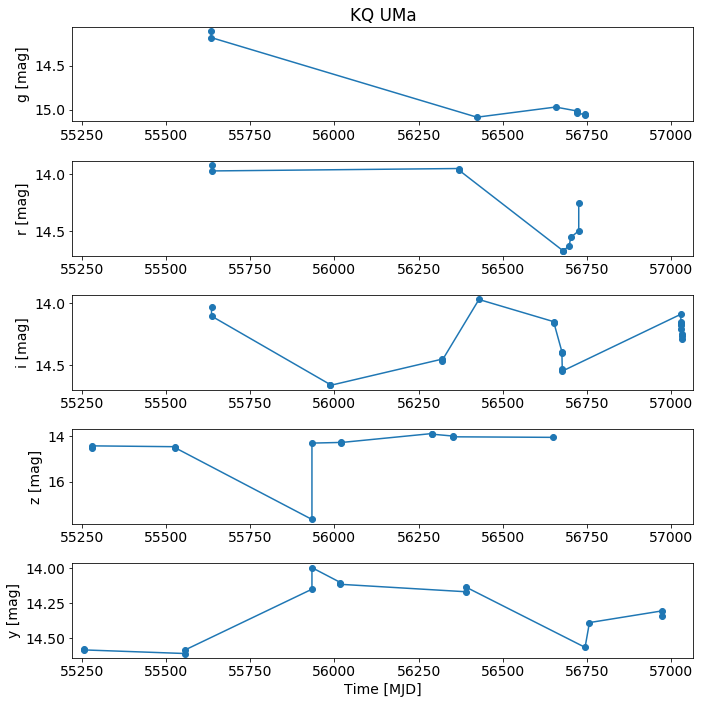

In [7]:
# convert flux in Jy to magnitudes
t = dtab['obsTime']
mag = -2.5*np.log10(dtab['psfFlux']) + 8.90
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
for i, filter in enumerate("grizy"):
    pylab.subplot(511+i)
    w = np.where(dtab['filter']==filter)
    pylab.plot(t[w],mag[w],'-o')
    pylab.ylabel(filter+' [mag]')
    pylab.xlim(xlim)
    pylab.gca().invert_yaxis()
    if i==0:
        pylab.title(objname)
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

Plot differences from the mean magnitudes in the initial search.

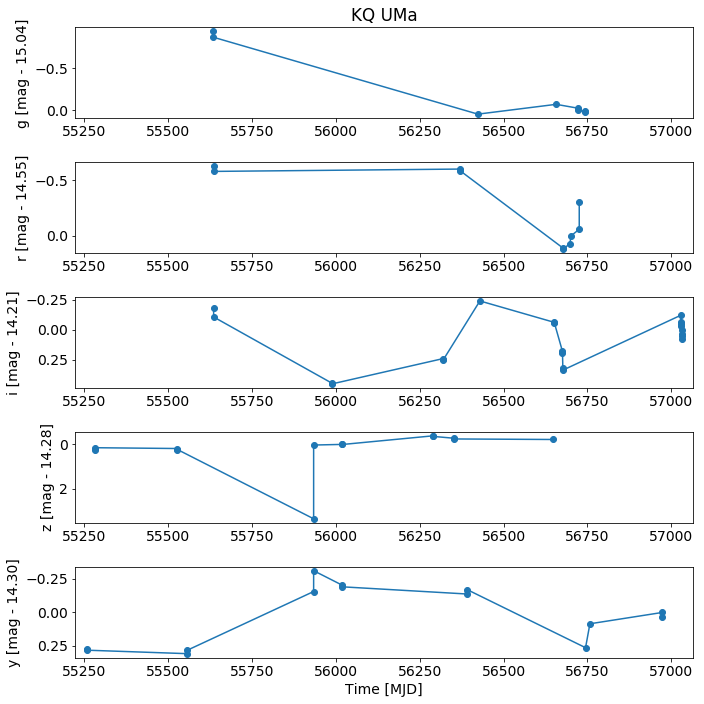

In [8]:
# convert flux in Jy to magnitudes
t = dtab['obsTime']
mag = -2.5*np.log10(dtab['psfFlux']) + 8.90
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
for i, filter in enumerate("grizy"):
    pylab.subplot(511+i)
    w = np.where(dtab['filter']==filter)
    magmean = tab[filter+'MeanPSFMag'][0]
    pylab.plot(t[w],mag[w] - magmean,'-o')
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean))
    pylab.xlim(xlim)
    pylab.gca().invert_yaxis()
    if i==0:
        pylab.title(objname)
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

### Identify bad data

There is one clearly bad $z$ magnitude with a very large difference.  Select the bad point and look at it in more detail.

Note that indexing a table (or numpy array) with a logical expression selects just the rows where that expression is true.

In [9]:
dtab[ (dtab['filter']=='z') & (np.abs(mag-tab['zMeanPSFMag'][0]) > 2) ]

objID,detectID,filter,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3
int64,int64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64
190361393344112894,183252627520000234,z,55933.5264577,139.33488168,68.63532273,0.000317945,6.73008e-06,1.07537,1.0153,0.322986,0.000213217,2.36939e-06,102760453,128,32768


From examining this table, it looks like `psfQfPerfect` is bad.  This flag is the PSF-weighted fraction of unmasked pixels in the image (see the [documentation](https://outerspace.stsci.edu/x/IoOc) for more details). Values near unity indicate good data that is not significantly affected by bad pixels.

Check all the `psfQfPerfect` values for the $z$ filter to see if this value really is unusual.  The list of values below are sorted by magnitude.  The bad point is the only value with `psfQfPerfect` < 0.95.

In [10]:
w = np.where(dtab['filter']=='z')
zdtab = dtab[w]
zdtab['mag'] = mag[w]
zdtab['dmag'] = zdtab['mag'] - tab['zMeanPSFMag'][0]
ii = np.argsort(-np.abs(zdtab['dmag']))
zdtab = zdtab[ii]
zdtab['objID','obsTime','mag','dmag','psfQfPerfect']

objID,obsTime,mag,dmag,psfQfPerfect
int64,float64,float64,float64,float64
190361393344112894,55933.5264577,17.64412000084374,3.362720000843739,0.322986
190361393344112894,56289.6159346,13.890659532156441,-0.39074046784355865,0.997811
190361393344112894,56289.6241112,13.916806313581588,-0.36459368641841117,0.988369
190361393344112894,56351.4168483,13.998972905236004,-0.28242709476399597,0.999257
190361393344112894,55281.2528285,14.537914638686473,0.2565146386864736,0.99754
190361393344112894,56351.424076,14.032501974717418,-0.24889802528258187,0.999187
190361393344112894,55527.6508919,14.51211820687871,0.23071820687871103,0.997265
190361393344112894,56648.5676019,14.056429712068542,-0.22497028793145724,0.997982
190361393344112894,55527.6381469,14.465140973324303,0.18374097332430317,0.99738


### Repeat the plot with bad psfQfPerfect values excluded

Do the plot again but exclude low psfQfPerfect values.

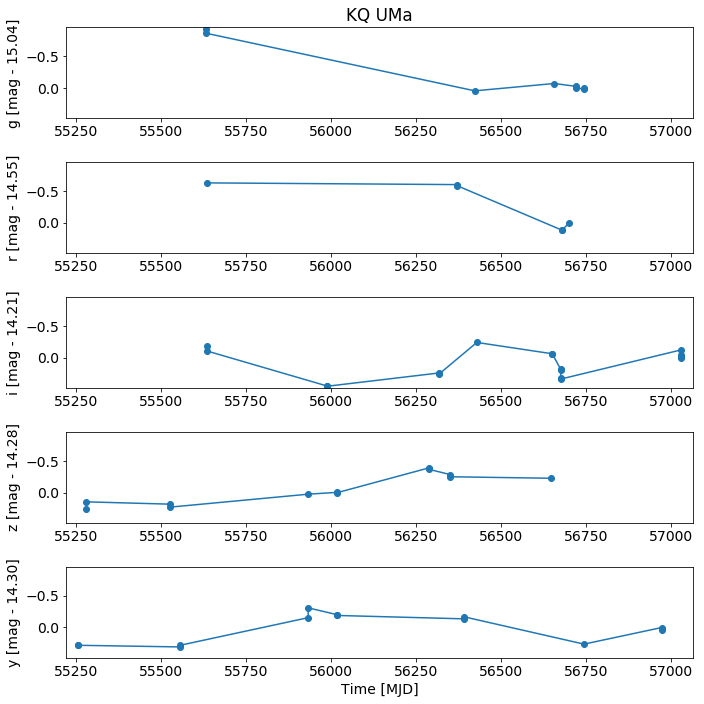

In [11]:
# convert flux in Jy to magnitudes
t = dtab['obsTime']
mag = -2.5*np.log10(dtab['psfFlux']) + 8.90
magmean = 0.0*mag
for filter in "grizy":
    magmean[dtab['filter']==filter] = tab[filter+'MeanPSFMag'][0]
dmag = mag - magmean
dmag1 = dmag[dtab['psfQfPerfect']>0.9]
# fix the x and y axis ranges
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
# flip axis direction for magnitude
ylim = np.array([dmag1.max(),dmag1.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
for i, filter in enumerate("grizy"):
    pylab.subplot(511+i)
    w = np.where((dtab['filter']==filter) & (dtab['psfQfPerfect']>0.9))[0]
    pylab.plot(t[w],dmag[w],'-o')
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean[w[0]]))
    pylab.xlim(xlim)
    pylab.ylim(ylim)
    if i==0:
        pylab.title(objname)
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

### Plot versus the periodic phase instead of epoch

Plot versus phase using known RR Lyr period from Simbad (table [J/AJ/132/1202/table4](http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/AJ/132/1202/table4&-c=KQ%20UMa&-c.u=arcmin&-c.r=2&-c.eq=J2000&-c.geom=r&-out.max=50&-out.form=HTML%20Table&-oc.form=sexa)).

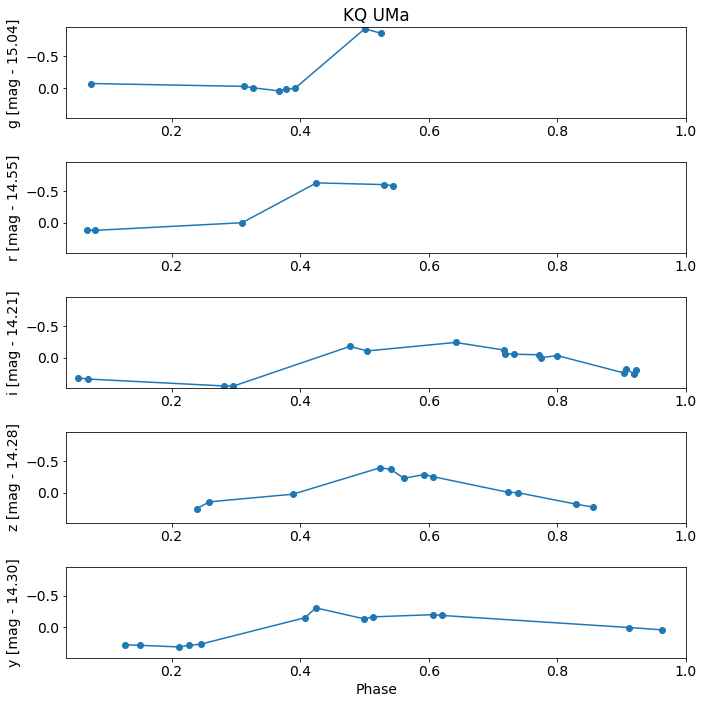

In [12]:
period = 0.48636
# convert flux in Jy to magnitudes
t = (dtab['obsTime'] % period) / period
mag = -2.5*np.log10(dtab['psfFlux']) + 8.90
magmean = 0.0*mag
for filter in "grizy":
    magmean[dtab['filter']==filter] = tab[filter+'MeanPSFMag'][0]
dmag = mag - magmean
dmag1 = dmag[dtab['psfQfPerfect']>0.9]
# fix the x and y axis ranges
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
# flip axis direction for magnitude
ylim = np.array([dmag1.max(),dmag1.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
for i, filter in enumerate("grizy"):
    pylab.subplot(511+i)
    w = np.where((dtab['filter']==filter) & (dtab['psfQfPerfect']>0.9))[0]
    w = w[np.argsort(t[w])]
    pylab.plot(t[w],dmag[w],'-o')
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean[w[0]]))
    pylab.xlim(xlim)
    pylab.ylim(ylim)
    if i==0:
        pylab.title(objname)
pylab.xlabel('Phase')
pylab.tight_layout()

## Repeat search using eclipsing binary KIC 2161623

From [Villanova Kepler Eclipsing Binaries](http://keplerebs.villanova.edu)

In [13]:
objname = 'KIC 2161623'
ra, dec = resolve(objname)
radius = 1.0/60.0 # radius = 1 arcsec

query = """select o.objID, o.raMean, o.decMean,
o.nDetections, o.ng, o.nr, o.ni, o.nz, o.ny,
m.gMeanPSFMag, m.rMeanPSFMag, m.iMeanPSFMag, m.zMeanPSFMag, m.yMeanPSFMag
from fGetNearestObjEq({},{},{}) nb
inner join ObjectThin o on o.objid=nb.objid and o.nDetections>1
inner join MeanObject m on o.objid=m.objid and o.uniquePspsOBid=m.uniquePspsOBid
""".format(ra,dec,radius)

print(query)

jobs = mastcasjobs.MastCasJobs(context="PanSTARRS_DR2")
results = jobs.quick(query, task_name="python cone search")
tab = fixcolnames(ascii.read(results))
tab

select o.objID, o.raMean, o.decMean,
o.nDetections, o.ng, o.nr, o.ni, o.nz, o.ny,
m.gMeanPSFMag, m.rMeanPSFMag, m.iMeanPSFMag, m.zMeanPSFMag, m.yMeanPSFMag
from fGetNearestObjEq(291.7444617740266,37.5910012223162,0.016666666666666666) nb
inner join ObjectThin o on o.objid=nb.objid and o.nDetections>1
inner join MeanObject m on o.objid=m.objid and o.uniquePspsOBid=m.uniquePspsOBid



objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
153102917444859851,291.74446451,37.5910001,67,10,16,12,15,14,14.5998,14.2821,14.1587,14.2004,14.0672


### Get the detection information

This time include the `psfQfPerfect` limit directly in the database query.

In [14]:
objid = tab['objID'][0]
query = """select 
    objID, detectID, filter=f.filterType, obsTime, ra, dec,
    psfFlux, psfFluxErr, psfMajorFWHM, psfMinorFWHM, psfQfPerfect, 
    apFlux, apFluxErr, infoFlag, infoFlag2, infoFlag3
from (
    select * from Detection where objID={}
    ) d
join Filter f on d.filterID=f.filterID
where psfQfPerfect>0.9
order by d.filterID, obsTime
""".format(objid)

print(query)

dresults = jobs.quick(query, task_name="python detection search")
dtab = fixcolnames(ascii.read(dresults))

# add magnitude and difference from mean
dtab['magmean'] = 0.0
for filter in "grizy":
    dtab['magmean'][dtab['filter']==filter] = tab[filter+'MeanPSFMag'][0]
dtab['mag'] = -2.5*np.log10(dtab['psfFlux']) + 8.90
dtab['dmag'] = dtab['mag']-dtab['magmean']
dtab

select 
    objID, detectID, filter=f.filterType, obsTime, ra, dec,
    psfFlux, psfFluxErr, psfMajorFWHM, psfMinorFWHM, psfQfPerfect, 
    apFlux, apFluxErr, infoFlag, infoFlag2, infoFlag3
from (
    select * from Detection where objID=153102917444859851
    ) d
join Filter f on d.filterID=f.filterID
where psfQfPerfect>0.9
order by d.filterID, obsTime



objID,detectID,filter,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3,magmean,mag,dmag
int64,int64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64
153102917444859851,90150443710000088,g,55002.5047803,291.74446391,37.5910006,0.00501008,6.65687e-06,1.98744,1.81211,0.999421,0.00517413,7.31225e-06,102760517,128,124815424,14.5998,14.650388348365238,0.05058834836523829
153102917444859851,90151959710000087,g,55002.5199475,291.74446611,37.59100156,0.00487334,6.48844e-06,1.98487,1.70793,0.999234,0.00511542,7.27714e-06,102760517,128,124815424,14.5998,14.680433219970322,0.08063321997032169
153102917444859851,131534996560000129,g,55416.3502179,291.74446082,37.59099692,0.00525622,8.41646e-06,1.62403,1.57893,0.998566,0.0052992,8.62578e-06,102760517,128,7374912,14.5998,14.598316163992422,-0.0014838360075781765
153102917444859851,131536180650000138,g,55416.362065,291.74445937,37.59099733,0.00533028,8.62169e-06,1.32081,1.27186,0.998757,0.00540082,8.91577e-06,102760517,128,124815424,14.5998,14.58312494213292,-0.016675057867079346
153102917444859851,204528930560000076,g,56146.2895546,291.74445914,37.59098073,0.00522399,8.43794e-06,1.33369,1.29211,0.999758,0.00532506,8.88465e-06,102760517,128,7374912,14.5998,14.604994157696247,0.0051941576962466485
153102917444859851,204530041560000085,g,56146.3006673,291.74446486,37.59097649,0.00523539,8.44281e-06,1.42883,1.22683,0.964646,0.00532419,8.85594e-06,102760517,128,7374912,14.5998,14.602627402183877,0.0028274021838772256
153102917444859851,241032265120000094,g,56511.322909,291.74445657,37.59099752,0.00528641,8.3427e-06,1.15123,1.10789,0.998722,0.00537484,8.8135e-06,102760517,128,7374912,14.5998,14.59209789291219,-0.007702107087810717
153102917444859851,241033321120000081,g,56511.3334693,291.74445945,37.59099643,0.00527889,8.31263e-06,1.07898,0.987323,0.995279,0.0053346,8.77771e-06,102760517,128,7374912,14.5998,14.59364346902239,-0.006156530977609265
153102917444859851,91252543710000102,r,55013.5256677,291.74445985,37.59099454,0.00700243,8.7848e-06,1.90187,1.68689,0.998962,0.00723513,9.82915e-06,102760517,128,7374912,14.2821,14.286878059801037,0.00477805980103696


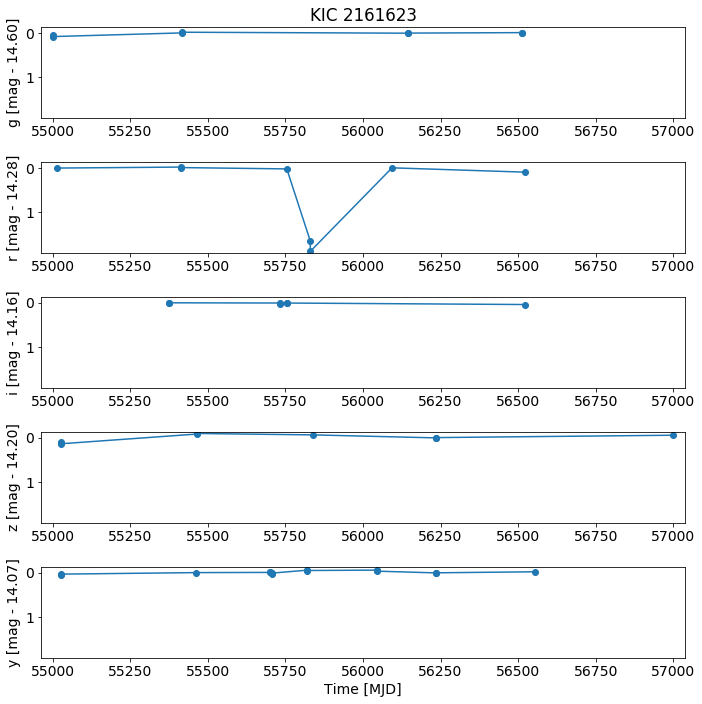

In [15]:
t = dtab['obsTime']
dmag = dtab['dmag']
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
ylim = np.array([dmag.max(),dmag.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
for i, filter in enumerate("grizy"):
    pylab.subplot(511+i)
    w = np.where(dtab['filter']==filter)[0]
    pylab.plot(t[w],dmag[w],'-o')
    magmean = dtab['magmean'][w[0]]
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean))
    pylab.xlim(xlim)
    pylab.ylim(ylim)
    if i==0:
        pylab.title(objname)
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

### Plot versus phase using known period

Eclipsing binaries basically vary by same amount in all filters since it is a geometrical effect, so combine the data into a single light curve.  Wrap using known period and plot versus phase.

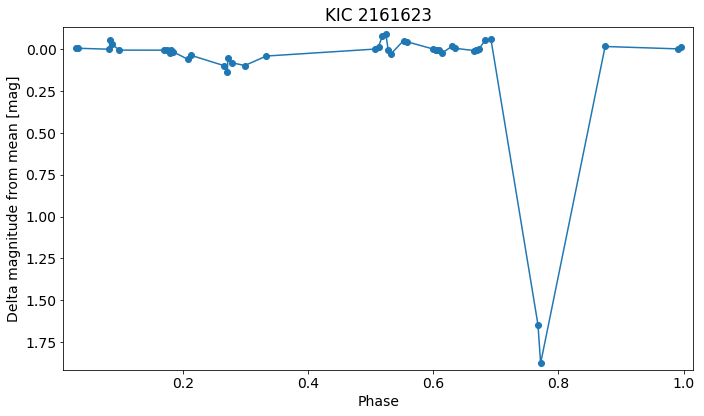

In [16]:
period = 2.2834698
bjd0 = 54999.599837
t = ((dtab['obsTime']-bjd0) % period) / period
dmag = dtab['dmag']
w = np.argsort(t)
t = t[w]
dmag = dmag[w]
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
ylim = np.array([dmag.max(),dmag.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,6))
pylab.plot(t,dmag,'-o')
pylab.xlim(xlim)
pylab.ylim(ylim)
pylab.xlabel('Phase')
pylab.ylabel('Delta magnitude from mean [mag]')
pylab.title(objname)
pylab.tight_layout()

## Repeat search for another eclipsing binary KIC 8153568

In [17]:
objname = 'KIC 8153568'
ra, dec = resolve(objname)
radius = 1.0/60.0 # radius = 1 arcsec

query = """select o.objID, o.raMean, o.decMean,
o.nDetections, o.ng, o.nr, o.ni, o.nz, o.ny,
m.gMeanPSFMag, m.rMeanPSFMag, m.iMeanPSFMag, m.zMeanPSFMag, m.yMeanPSFMag
from fGetNearestObjEq({},{},{}) nb
inner join ObjectThin o on o.objid=nb.objid and o.nDetections>1
inner join MeanObject m on o.objid=m.objid and o.uniquePspsOBid=m.uniquePspsOBid
""".format(ra,dec,radius)

jobs = mastcasjobs.MastCasJobs(context="PanSTARRS_DR2")
results = jobs.quick(query, task_name="python cone search")
tab = fixcolnames(ascii.read(results))
tab

objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
160802869044447231,286.90444402,44.00547369,88,16,15,31,10,16,15.1825,14.9899,14.8907,15.1999,14.8484


In [18]:
objid = tab['objID'][0]
query = """select 
    objID, detectID, filter=f.filterType, obsTime, ra, dec,
    psfFlux, psfFluxErr, psfMajorFWHM, psfMinorFWHM, psfQfPerfect, 
    apFlux, apFluxErr, infoFlag, infoFlag2, infoFlag3
from (
    select * from Detection where objID={}
    ) d
join Filter f on d.filterID=f.filterID
where psfQfPerfect>0.9
order by d.filterID, obsTime
""".format(objid)

dresults = jobs.quick(query, task_name="python detection search")
dtab = fixcolnames(ascii.read(dresults))

# add magnitude and difference from mean
dtab['magmean'] = 0.0
for filter in "grizy":
    dtab['magmean'][dtab['filter']==filter] = tab[filter+'MeanPSFMag'][0]
dtab['mag'] = -2.5*np.log10(dtab['psfFlux']) + 8.90
dtab['dmag'] = dtab['mag']-dtab['magmean']
dtab

objID,detectID,filter,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3,magmean,mag,dmag
int64,int64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64
160802869044447231,91336429430000113,g,55014.3646518,286.90443374,44.00547575,0.003109,5.98065e-06,1.78,1.23811,0.998335,0.00312447,5.69291e-06,102760517,128,7374912,15.1825,15.16844819489202,-0.014051805107978765
160802869044447231,91337480430000116,g,55014.3751566,286.90443894,44.00547502,0.00313056,6.00144e-06,1.66939,1.32773,0.998197,0.00315613,5.71358e-06,102760517,128,124815424,15.1825,15.160944920386187,-0.021555079613811756
160802869044447231,126057565120000092,g,55361.57592,286.90445317,44.00547451,0.00309573,6.72312e-06,1.7498,1.62422,0.998826,0.00310045,6.69387e-06,102760517,128,7374912,15.1825,15.173092310398793,-0.00940768960120586
160802869044447231,126058741130000111,g,55361.587678,286.90445157,44.00548065,0.00302815,6.57752e-06,1.62839,1.52579,0.998387,0.0031062,6.76425e-06,102760517,128,7374912,15.1825,15.197056539443459,0.01455653944345947
160802869044447231,128744126310000284,g,55388.4415151,286.9044502,44.00547891,0.000806462,3.51444e-06,1.10132,0.992501,0.997631,0.000810416,3.45294e-06,102760517,128,124815424,15.1825,16.63354022871333,1.45104022871333
160802869044447231,128745341310000249,g,55388.4536712,286.90445043,44.00547936,0.000981762,3.82737e-06,1.1085,1.07441,0.997491,0.000985584,3.78859e-06,102760517,128,124815424,15.1825,16.4199844541942,1.2374844541942007
160802869044447231,164544841720000097,g,55746.4486739,286.90445315,44.00547646,0.00306655,6.32653e-06,1.32851,1.16693,0.99831,0.00304733,6.63894e-06,102760517,128,40929344,15.1825,15.183374874402688,0.0008748744026885191
160802869044447231,164744408530000111,g,55748.4443394,286.90445207,44.00547835,0.00304057,6.5461e-06,1.37153,1.23193,0.998544,0.00307828,6.69725e-06,102760517,128,7374912,15.1825,15.192612484522545,0.010112484522545984
160802869044447231,164745526530000113,g,55748.4555151,286.90445275,44.0054797,0.00304728,6.57104e-06,1.27531,1.26424,0.998519,0.00308564,6.71944e-06,102760517,128,7374912,15.1825,15.1902190967472,0.0077190967472002825


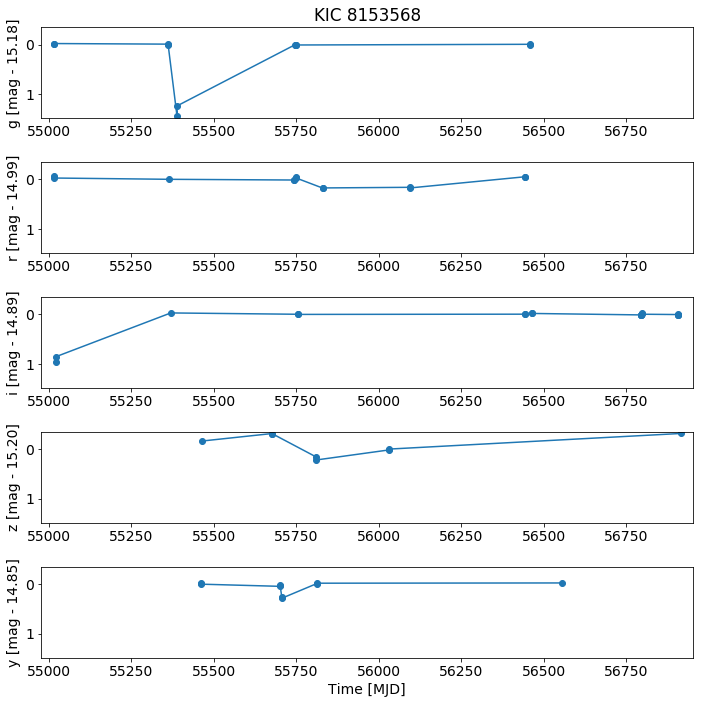

In [19]:
t = dtab['obsTime']
dmag = dtab['dmag']
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
ylim = np.array([dmag.max(),dmag.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
for i, filter in enumerate("grizy"):
    pylab.subplot(511+i)
    w = np.where(dtab['filter']==filter)[0]
    pylab.plot(t[w],dmag[w],'-o')
    magmean = dtab['magmean'][w[0]]
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean))
    pylab.xlim(xlim)
    pylab.ylim(ylim)
    if i==0:
        pylab.title(objname)
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

Eclipsing binaries basically vary by same amount in all filters since it is a geometrical effect, so combine the data into a single light curve.

Wrap using known period and plot versus phase.  Plot two periods of the light curve this time.

This nice light curve appears to show a secondary eclipse.

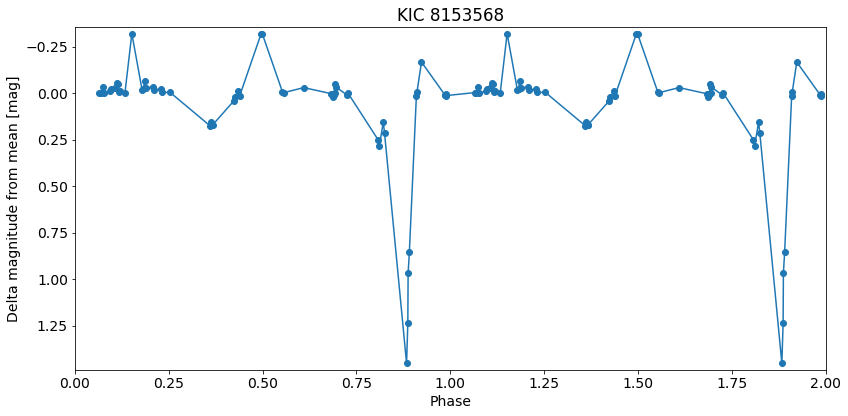

In [20]:
period = 3.6071431
bjd0 = 54999.289794
t = ((dtab['obsTime']-bjd0) % period) / period
dmag = dtab['dmag']
w = np.argsort(t)
# extend to two periods
nw = len(w)
w = np.append(w,w)
t = t[w]
# add one to second period
t[-nw:] += 1
dmag = dmag[w]
xlim = [0,2.0]
ylim = np.array([dmag.max(),dmag.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(12,6))
pylab.plot(t,dmag,'-o')
pylab.xlim(xlim)
pylab.ylim(ylim)
pylab.xlabel('Phase')
pylab.ylabel('Delta magnitude from mean [mag]')
pylab.title(objname)
pylab.tight_layout()